# Road type data to area of prediction

This notebooks integrates proximity to different road types to the area of prediction

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import distancerasters as dr

import matplotlib.pyplot as plt
import seaborn as sns

import aup

## Data download/read and preprocessing

### Area of prediction with variables

In [2]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/tess_kde.geojson')
print(aop_gdf.shape)
aop_gdf.head(2)

(294835, 28)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,pobtot,cultural_recreativo,...,uso_tot,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria,geometry
0,0,Servicio,2747.599834,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,0.009869,0,0.0,...,4.926511,0.0,0.0,0.740466,0.231342,0.0,0.0,0.0,0.028192,"POLYGON ((2349620.239 965525.905, 2349619.865 ..."
1,1,Sin dato,900.765482,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,0.003235,0,0.0,...,58.144456,0.0,0.0,0.586683,0.354285,0.0,0.0,0.0,0.059033,"POLYGON ((2349506.214 965639.352, 2349505.838 ..."


### Area of analysis

In [3]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito/distrito.shp")
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 2)


,id,geometry
0,1,"POLYGON ((-103.4233 20.91026, -103.42209 20.91..."


### Edges

In [4]:
schema = "osmnx"
table = "edges_osmnx_23_line"

edges = aup.gdf_from_polygon(aoa_gdf, schema, table)
print(edges.shape)
edges.head(2)

(146103, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,701379894,1742199439,1665230207,0,False,None,Privada Fresno,residential,None,85.256,"LINESTRING (-103.42168 20.58715, -103.42172 20...",None,None,None,None,None,None,None,Guadalajara
1,467372703,1873910987,1665442630,0,False,None,Avenida Los Cajetes,residential,None,68.582,"LINESTRING (-103.42383 20.58681, -103.42389 20...",None,None,None,None,None,None,None,Guadalajara


#### Road type processing

Transform lists stored as strings to list

In [5]:
from ast import literal_eval

In [6]:
def check_for_lists(val):
    try:
        val = literal_eval(val)
        return val
    except:
        return val

In [7]:
edges['highway'] = edges.highway.apply(lambda row: check_for_lists(row))

In [8]:
edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list)),'highway'] = edges.loc[
    edges.highway.map(lambda x: isinstance(x, list))].apply(
        lambda row: row['highway'][0], axis=1)

Check process

In [9]:
len(edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list))])

0

#### Remove link sections

In [10]:
edges.loc[edges['highway'].str.contains(
    "_link"),'highway'] = edges[edges['highway'].str.contains(
    "_link")].highway.apply(lambda x: x.replace('_link',''))

Check result

In [11]:
len(edges.loc[edges['highway'].str.contains(
    "_link"),'highway'])

0

In [12]:
edges.highway.unique()

array(['residential', 'primary', 'service', 'track', 'path', 'tertiary',
       'living_street', 'footway', 'cycleway', 'secondary', 'steps',
       'pedestrian', 'trunk', 'unclassified', 'motorway', 'corridor',
       'bridleway'], dtype=object)

## Road type proximity to area of analysis

#### Test the algorithm

Rasterize road data

In [13]:
edges = edges.to_crs("EPSG:4326")
aop_gdf = aop_gdf.to_crs("EPSG:4326")

In [14]:
road_type = 'primary'
edges_test = edges.loc[edges.highway==road_type].copy()
print(edges_test.shape)
edges_test.head(2)

(2455, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
54,653450225,6148237946,4620035014,0,True,3,Antiguo Camino Real a Colima,primary,None,16.516,"LINESTRING (-103.42038 20.58717, -103.4205 20....",None,None,None,None,None,None,None,Guadalajara
65,653450225,8694189056,6148237946,0,True,3,Antiguo Camino Real a Colima,primary,None,241.384,"LINESTRING (-103.4205 20.58707, -103.42231 20....",None,None,None,None,None,None,None,Guadalajara


In [15]:
pixel_size = 0.00023 # 0.00023° -> 25m

In [16]:
# define bounds according to area of prediction
bounds = []
for c in aop_gdf.bounds:
    if 'min' in c:
        bounds.append(aop_gdf.bounds[c].min().item())
    else:
        bounds.append(aop_gdf.bounds[c].max().item())
bounds = tuple(bounds)
bounds

(-103.55543607998213,
 20.58493855031059,
 -103.32083786014029,
 20.859713137410953)

In [17]:
output_dir = '../../data/processed/prediccion_uso_suelo/prox_vialidades/'

rv_array, affine = dr.rasterize(edges_test, pixel_size=pixel_size,
                                bounds=bounds, 
                                output=output_dir+f"{road_type}_rasterized.tif")

In [18]:
affine

Affine(0.00023, 0.0, -103.55565999999999,
       0.0, -0.00023, 20.859849999999998)

Proximity raster

In [19]:
def raster_conditional(rarray):
    return (rarray == 1)

# generate distance array and output to geotiff
my_dr = dr.DistanceRaster(rv_array, affine=affine,
                          output_path=output_dir+f"{road_type}_distance.tif",
                          conditional=raster_conditional)

Tree build time: 0.0023 seconds
Distance calc run time: 12.3217 seconds


In [20]:
my_dr

## Data to area of prediction

Test raster output

In [27]:
import rasterio
from tqdm import tqdm, tqdm_pandas

In [22]:
with rasterio.open(output_dir+f"{road_type}_distance.tif") as src:
    affine = src.transform
    distance_raster = src.read(1)

In [23]:
distance_raster

array([[ 8961.59158387,  8945.28686799,  8926.58219061, ...,
         7629.72445614,  7637.32196362,  7644.98666112],
       [ 8942.92737892,  8926.58854732,  8910.28387929, ...,
         7605.46865441,  7613.09037972,  7620.77946023],
       [ 8924.297431  ,  8907.92440355,  8891.5854858 , ...,
         7581.22152254,  7588.86761168,  7596.58122173],
       ...,
       [12625.79934323, 12603.79030086, 12581.78830401, ...,
         9630.41336481,  9651.3065035 ,  9672.21375777],
       [12635.87933103, 12613.88784328, 12591.90345682, ...,
         9642.94149586,  9663.80758023,  9684.68787875],
       [12646.00300584, 12624.02912071, 12602.06239262, ...,
         9655.52111237,  9676.36010153,  9697.21340308]],
      shape=(1195, 1020))

Distance raster to area of prediction

In [33]:
tqdm.pandas()

0it [00:13, ?it/s]


In [34]:
raster_distance = rasterio.open(output_dir+f"{road_type}_distance.tif")

In [35]:
aop_gdf[road_type+'_distance'] = aop_gdf.geometry.progress_apply(
                lambda geom: aup.clean_mask(geom, raster_distance)).apply(np.ma.mean)

100%|███████████████████████████████████████████████████| 294835/294835 [01:32<00:00, 3186.71it/s]


In [36]:
print(aop_gdf.shape)
aop_gdf.head(2)

(294835, 29)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,pobtot,cultural_recreativo,...,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria,geometry,primary_distance
0,0,Servicio,2747.599834,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,0.009869,0,0.0,...,0.0,0.0,0.740466,0.231342,0.0,0.0,0.0,0.028192,"POLYGON ((-103.44956 20.6901, -103.44957 20.69...",818.237260
1,1,Sin dato,900.765482,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,0.003235,0,0.0,...,0.0,0.0,0.586683,0.354285,0.0,0.0,0.0,0.059033,"POLYGON ((-103.45067 20.69112, -103.45068 20.6...",739.083904


<Axes: >

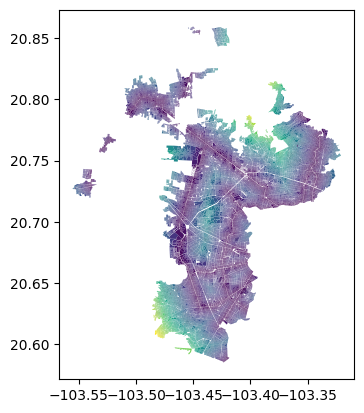

In [37]:
aop_gdf.plot('primary_distance')

## Save data